Digit Recognizer (MNIST)
=================================

This is an implementation of [Kaggle competition for recognizing digits](https://www.kaggle.com/c/digit-recognizer)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
import ImageUtils
import DataUtils

First let's investigate the training dataset, we first read the file, with seperater as `,` and specify that the first row is the header. We can then use the header as our dictionary key

In [3]:
train_data = pd.read_csv('train.csv', sep=',',header=0)
training_labels = train_data['label'].values
training_values = train_data.drop('label', 1).values

test_data = pd.read_csv('test.csv', sep=',',header=0)
test_values = test_data.values

print("There are a total of {} training images".format(len(train_data)))
print("There are a total of {} test images".format(len(test_data)))

There are a total of 42000 training images
There are a total of 28000 test images


## Dataset visualization

Now we try to investigate and print some of the data to understand the dataset, we start from index 0 and try every other image

The image is 1
The image is 0
The image is 7


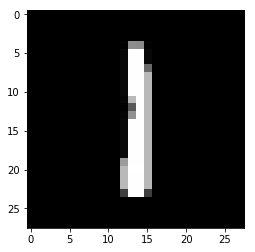

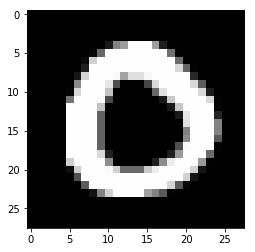

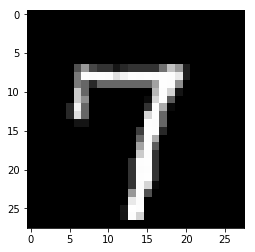

In [9]:
for x in range(2,8, 2):
    row = DataUtils.reshape_row(training_values[x])
    ImageUtils.show_mnist_image(row)
    print("The image is {}".format(training_labels[x]))

Let's try visualizing the test dataset, we only have test dataset values, but no targets, which means we would have to split out training dataset into test dataset for training the neural network,

The reason why the Kaggel provided test dataset exists, is so that we run the test dataset through our neural network and output the values which would be checked against the test targets (that data is only with Kaggle)

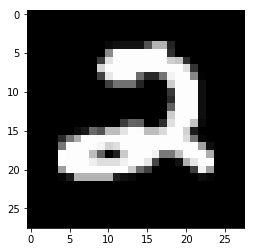

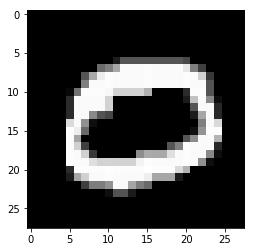

In [11]:
for x in range(0, 3):
    row = DataUtils.reshape_row(test_values[x])
    ImageUtils.show_mnist_image(row)